<a href="https://colab.research.google.com/github/nineto1/section_project/blob/main/AI_05_%EC%9D%B4%EA%B3%84%ED%98%84_Section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install --upgrade category_encoders
#!pip install --upgrade imbalanced-learn
#!pip install --upgrade eli5
#!pip install --upgrade pdpbox
#!pip install --upgrade shap

In [ ]:
##### original data load #####

import pandas as pd
from glob import glob
from IPython.display import display
import numpy as np

path = '/content/drive/MyDrive/data/section2_proj/coupon_redeem/'

campaign_data = pd.read_csv(path+'campaign_data.csv')
coupon_item_mapping = pd.read_csv(path+'coupon_item_mapping.csv')
customer_demographics = pd.read_csv(path+'customer_demographics.csv')
customer_transaction_data = pd.read_csv(path+'customer_transaction_data.csv')
item_data = pd.read_csv(path+'item_data.csv')
train = pd.read_csv(path+'train.csv')
#test = pd.read_csv(path+'test.csv')

# data preview
def preview(path):
    for filename in glob(path+'*.csv'):
        df = pd.read_csv(filename)
        print(filename.split('/')[-1], df.shape)
        display(df.head())
        print('\n')

preview(path)

campaign_data.csv (28, 4)


,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13




customer_demographics.csv (760, 7)


,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5




coupon_item_mapping.csv (92663, 2)


,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77




test.csv (50226, 4)


,id,campaign_id,coupon_id,customer_id
0,3,22,869,967
1,4,20,389,1566
2,5,22,981,510
3,8,25,1069,361
4,10,17,498,811




train.csv (78369, 5)


,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0




item_data.csv (74066, 4)


,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery




customer_transaction_data.csv (1324566, 7)


,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0


In [ ]:
from sklearn.model_selection import train_test_split

# train, validataion, test set 으로 데이터 분리
target = 'redemption_status'
print(train[target].value_counts(normalize = True))

train, test = train_test_split(train, train_size = 0.8, test_size=0.2, random_state=2, stratify=train[target])
train, val = train_test_split(train, train_size = 0.8, test_size=0.2, random_state=2, stratify=train[target])

0    0.990709
1    0.009291
Name: redemption_status, dtype: float64


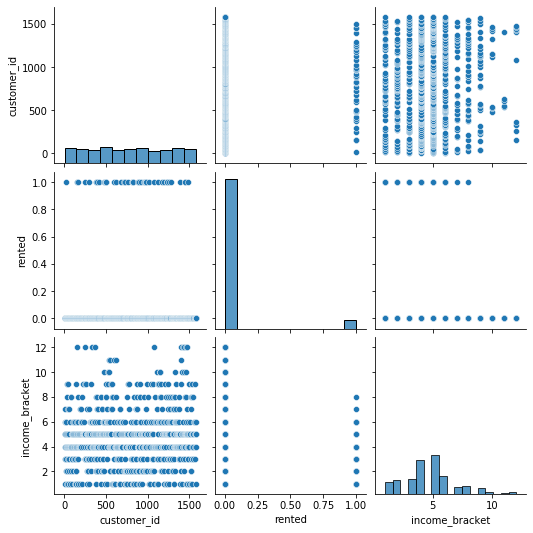

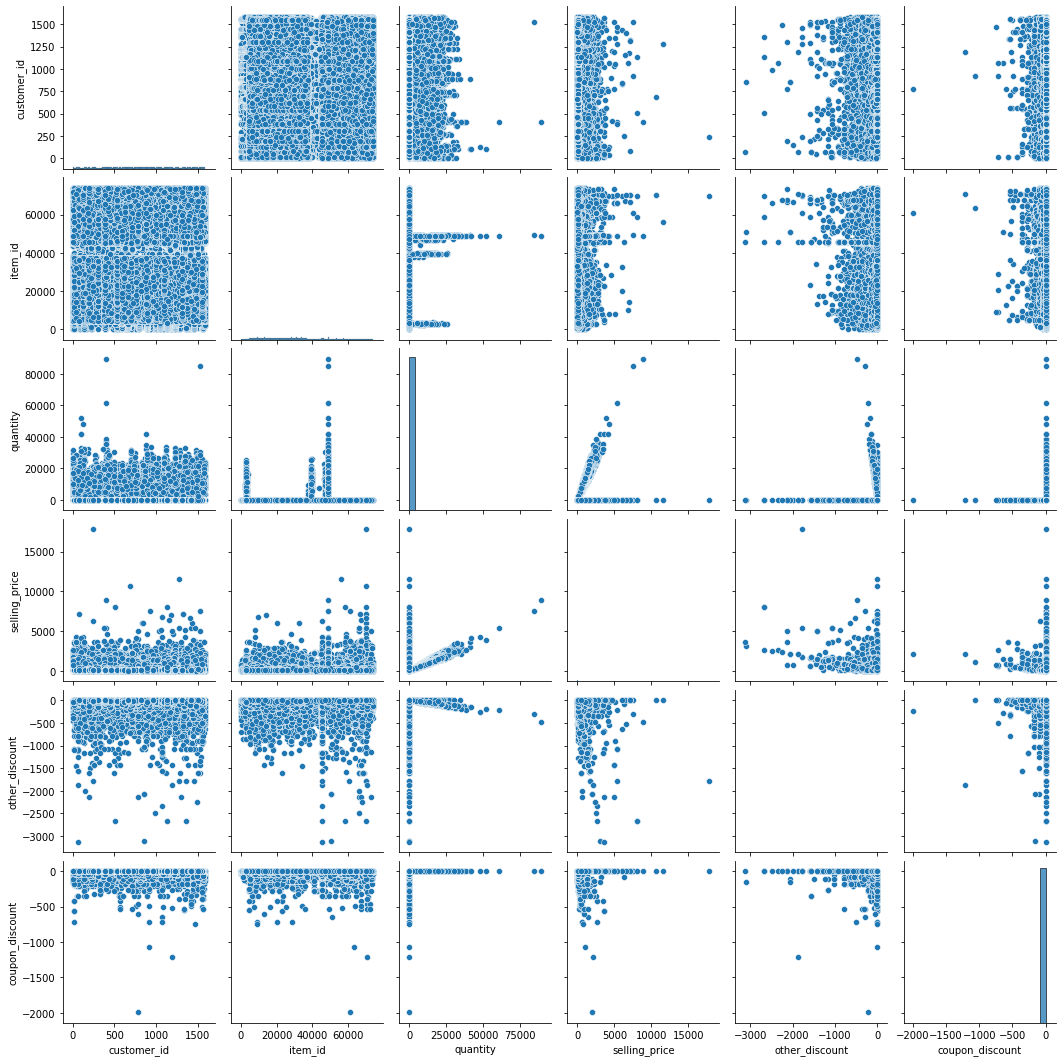

In [ ]:
import seaborn as sns

# 고객데이터, 고객 거래 데이터 상관관계 그래프 
sns.pairplot(data = customer_demographics)
sns.pairplot(data = customer_transaction_data)
plt.show()

In [ ]:
# campaign data 전처리 - 날짜 데이터 변경, type 을 0 or 1 로 변경
print(campaign_data.isna().sum())
print(campaign_data.dtypes)
def preprocessing_campaign_data(df) :
  df_copy = df
  df_copy['campaign_type'] = df_copy['campaign_type'].apply(lambda x : 1 if x == 'Y' else 0)
  df_copy['start_date'] = pd.to_datetime(df_copy['start_date'], format='%d/%m/%y')
  df_copy['end_date'] = pd.to_datetime(df_copy['end_date'], format='%d/%m/%y')
  return df_copy

campaign_data = preprocessing_campaign_data(campaign_data)


campaign_id      0
campaign_type    0
start_date       0
end_date         0
dtype: int64
campaign_id       int64
campaign_type    object
start_date       object
end_date         object
dtype: object


In [ ]:
# 구매날짜에 따라 Campaign Id 값 정리
def find_campaignIds(date) : 
  if date < pd.Timestamp('2012-08-01') :
    return [0];
  result = campaign_data[(campaign_data.start_date <= date) & (campaign_data.end_date >= date)].campaign_id.to_list()
  return result

customer_transaction_data['date'] = pd.to_datetime(customer_transaction_data['date'])

date_campaign_mapper = pd.DataFrame(customer_transaction_data.groupby(by = ['date']).sum().index, columns = ['date'])
date_campaign_mapper['campaign_id'] = date_campaign_mapper['date'].apply(find_campaignIds)

In [ ]:
##### coupon 에 대한 item 데이터 mapping ######
coupon_item_mapping = coupon_item_mapping.join(item_data.set_index('item_id'), on = 'item_id')

##### 구매 item 에 대한 item 데이터 mapping #######
customer_transaction_data = customer_transaction_data.join(item_data.set_index('item_id'), on = 'item_id')

display(coupon_item_mapping.head(5))
display(customer_transaction_data.head(5))

,coupon_id,item_id,brand,brand_type,category
0,105,37,56,Local,Grocery
1,107,75,56,Local,Grocery
2,494,76,209,Established,Grocery
3,522,77,278,Established,Grocery
4,518,77,278,Established,Grocery


,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,brand,brand_type,category
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0,56,Local,Natural Products
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0,56,Local,Natural Products
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0,524,Established,Grocery
3,2012-01-02,1501,33647,1,67.32,0.00,0.0,1134,Established,Grocery
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0,524,Established,Grocery


In [ ]:
##### Data wrangling ######

items_by_couponId = coupon_item_mapping.groupby(by = 'coupon_id').agg(set)
transaction_by_customer_id = customer_transaction_data.drop(columns = ['date']).groupby(by = 'customer_id')

# 훈련 데이터의 campaing id, customer id, coupon id 에 따라 campaign, coupon 에 대한 item, 고객 정보, 구매 item 정보 mapping
def add_feature(df) : 
  df_copy = df.copy()
  df_copy = df_copy.join(campaign_data.set_index('campaign_id'), on = 'campaign_id')
  df_copy = df_copy.join(customer_demographics.set_index('customer_id'), on = 'customer_id')
  df_copy = df_copy.join(items_by_couponId, on = 'coupon_id')
  df_copy.rename(columns = {'item_id' : 'items_by_coupon'}, inplace = True)
  df_copy.rename(columns = {'brand' : 'brand_by_coupon'}, inplace = True)
  df_copy.rename(columns = {'brand_type' : 'btype_by_coupon'}, inplace = True)
  df_copy.rename(columns = {'category' : 'cats_by_coupon'}, inplace = True)
  df_copy = df_copy.join(transaction_by_customer_id.sum().drop(columns = ['item_id', 'brand']), on = 'customer_id')
  df_copy = df_copy.join(transaction_by_customer_id.agg({'item_id' : set, 'brand' : set, 'brand_type' : set, 'category' : set}), on = 'customer_id')
  df_copy.rename(columns = {'item_id' : 'buying_items'}, inplace = True)
  df_copy.rename(columns = {'brand' : 'buying_brand'}, inplace = True)
  df_copy.rename(columns = {'brand_type' : 'buying_btype'}, inplace = True)
  df_copy.rename(columns = {'category' : 'buying__cats'}, inplace = True)
  return df_copy

train = add_feature(train)
val = add_feature(val)
test = add_feature(test)
display(train.head(5))

,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,age_range,marital_status,rented,family_size,no_of_children,income_bracket,items_by_coupon,brand_by_coupon,btype_by_coupon,cats_by_coupon,quantity,selling_price,other_discount,coupon_discount,buying_items,buying_brand,buying_btype,buying__cats
30411,49870,8,69,1484,0,0,2013-02-16,2013-04-05,NaN,NaN,NaN,NaN,NaN,NaN,"{418, 26883, 52136, 394, 51951, 22901, 51997}",{56},{Local},{Grocery},38566,38069.10,-7899.70,-67.68,"{15872, 16386, 13315, 51204, 34312, 17419, 342...","{1536, 1, 522, 533, 1562, 3099, 544, 5160, 553...","{Local, Established}","{Pharmaceutical, Bakery, Grocery, Packaged Mea..."
70638,116034,13,796,1036,0,0,2013-05-19,2013-07-05,36-45,NaN,0.0,2,NaN,9.0,"{1527, 3596, 30221, 32268, 44565, 44055, 53785...",{967},{Established},{Grocery},2147,185154.11,-27092.12,-124.67,"{34816, 63490, 24579, 14342, 22537, 20489, 553...","{1, 1025, 611, 1540, 5125, 4615, 8, 522, 1547,...","{Local, Established}","{Flowers & Plants, Skin & Hair Care, Pharmaceu..."
17195,28276,13,512,1253,0,0,2013-05-19,2013-07-05,NaN,NaN,NaN,NaN,NaN,NaN,"{39299, 19619, 68422, 35399, 12872, 16935, 305...",{244},{Established},{Grocery},596,68633.65,-9067.33,-12.47,"{30723, 57355, 12316, 8223, 18475, 6190, 14383...","{1025, 1, 1540, 5129, 522, 524, 2062, 1041, 15...","{Local, Established}","{Skin & Hair Care, Flowers & Plants, Pharmaceu..."
31242,51193,13,406,1216,0,0,2013-05-19,2013-07-05,26-35,NaN,0.0,4,2,8.0,"{56505, 24546, 36129, 7977}",{57},{Established},{Pharmaceutical},480319,213477.92,-23476.55,-1113.10,"{12291, 6153, 14345, 24587, 24588, 36875, 1844...","{1, 1539, 5125, 2054, 522, 11, 2060, 524, 4619...","{Local, Established}","{Pharmaceutical, Bakery, Seafood, Alcohol, Pre..."
12812,21148,26,1009,121,0,0,2012-08-12,2012-09-21,NaN,NaN,NaN,NaN,NaN,NaN,"{41218, 33155, 40590, 11921, 13715, 46233, 391...","{4700, 1487}",{Established},{Natural Products},214,12450.20,-2585.97,-142.48,"{15874, 69123, 36357, 15881, 26125, 34831, 220...","{387, 133, 905, 1162, 524, 141, 1041, 914, 533...","{Local, Established}","{Pharmaceutical, Grocery, Dairy, Juices & Snac..."


In [ ]:
# 각 특성에 대한 데이터 변경 및 새로운 특성 생성.
def feature_modify(df) :
  df_copy = df.copy()
  df_copy['other_discount'] = df_copy['other_discount'].apply(lambda x : abs(x))
  df_copy['coupon_discount'] = df_copy['coupon_discount'].apply(lambda x : abs(x))
  df_copy['campaign_duration'] = (df_copy['end_date'] - df_copy['start_date']).astype(str)
  df_copy['campaign_duration'] = df_copy['campaign_duration'].apply(lambda x : int(x.split(' ')[0]))
  buying_items_among_coupon_items = [] # coupon 으루 구매가능한 item 중 구매경험이 있는 item 개수
  buying_cats_among_coupon_cats = [] # coupon 으루 구매가능한 category 중 구매경험이 있는 category 개수
  buying_brand_among_coupon_brand = [] # coupon 으루 구매가능한 brand 중 구매경험이 있는 brand 개수
  buying_btype_among_coupon_btype = [] # coupon 으루 구매가능한 brand type 중 구매경험이 있는 brand type 개수
  for idx in df_copy.index :    
    buying_items_among_coupon_items.append(len(df_copy.at[idx, 'items_by_coupon'] & df_copy.at[idx, 'buying_items']))
    buying_cats_among_coupon_cats.append(len(df_copy.at[idx, 'cats_by_coupon'] & df_copy.at[idx, 'buying__cats']))
    buying_brand_among_coupon_brand.append(len(df_copy.at[idx, 'brand_by_coupon'] & df_copy.at[idx, 'buying_brand']))
    buying_btype_among_coupon_btype.append(len(df_copy.at[idx, 'btype_by_coupon'] & df_copy.at[idx, 'buying_btype']))

  df_copy['buying_items_among_coupon_items'] = buying_items_among_coupon_items  
  df_copy['buying_brand_among_coupon_brand'] = buying_brand_among_coupon_brand  
  df_copy['buying_btype_among_coupon_btype'] = buying_btype_among_coupon_btype  
  df_copy['buying_cats_among_coupon_cats'] = buying_cats_among_coupon_cats
  df_copy['total_discount_rate'] = (df_copy['other_discount'] + df_copy['coupon_discount']) / df_copy['selling_price'] # 판매가에 대한 총할인 비율
  df_copy['coupon_discount_rate'] = df_copy['coupon_discount'] / df_copy['selling_price'] # 판매가에 대한 coupon 할일 비율
  df_copy['no_of_children'] = df_copy['no_of_children'].fillna(value = 0) # 자식수에 대한 결측치 처리.
  return df_copy

train = feature_modify(train)
val = feature_modify(val)
test = feature_modify(test)
display(train.head())

,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,age_range,marital_status,rented,family_size,no_of_children,income_bracket,items_by_coupon,brand_by_coupon,btype_by_coupon,cats_by_coupon,quantity,selling_price,other_discount,coupon_discount,buying_items,buying_brand,buying_btype,buying__cats,campaign_duration,buying_items_among_coupon_items,buying_brand_among_coupon_brand,buying_btype_among_coupon_btype,buying_cats_among_coupon_cats,total_discount_rate,coupon_discount_rate
30411,49870,8,69,1484,0,0,2013-02-16,2013-04-05,NaN,NaN,NaN,NaN,0,NaN,"{418, 26883, 52136, 394, 51951, 22901, 51997}",{56},{Local},{Grocery},38566,38069.10,7899.70,67.68,"{15872, 16386, 13315, 51204, 34312, 17419, 342...","{1536, 1, 522, 533, 1562, 3099, 544, 5160, 553...","{Local, Established}","{Pharmaceutical, Bakery, Grocery, Packaged Mea...",48,0,1,1,1,0.209287,0.001778
70638,116034,13,796,1036,0,0,2013-05-19,2013-07-05,36-45,NaN,0.0,2,0,9.0,"{1527, 3596, 30221, 32268, 44565, 44055, 53785...",{967},{Established},{Grocery},2147,185154.11,27092.12,124.67,"{34816, 63490, 24579, 14342, 22537, 20489, 553...","{1, 1025, 611, 1540, 5125, 4615, 8, 522, 1547,...","{Local, Established}","{Flowers & Plants, Skin & Hair Care, Pharmaceu...",47,0,0,1,1,0.146995,0.000673
17195,28276,13,512,1253,0,0,2013-05-19,2013-07-05,NaN,NaN,NaN,NaN,0,NaN,"{39299, 19619, 68422, 35399, 12872, 16935, 305...",{244},{Established},{Grocery},596,68633.65,9067.33,12.47,"{30723, 57355, 12316, 8223, 18475, 6190, 14383...","{1025, 1, 1540, 5129, 522, 524, 2062, 1041, 15...","{Local, Established}","{Skin & Hair Care, Flowers & Plants, Pharmaceu...",47,0,0,1,1,0.132294,0.000182
31242,51193,13,406,1216,0,0,2013-05-19,2013-07-05,26-35,NaN,0.0,4,2,8.0,"{56505, 24546, 36129, 7977}",{57},{Established},{Pharmaceutical},480319,213477.92,23476.55,1113.10,"{12291, 6153, 14345, 24587, 24588, 36875, 1844...","{1, 1539, 5125, 2054, 522, 11, 2060, 524, 4619...","{Local, Established}","{Pharmaceutical, Bakery, Seafood, Alcohol, Pre...",47,0,1,1,1,0.115186,0.005214
12812,21148,26,1009,121,0,0,2012-08-12,2012-09-21,NaN,NaN,NaN,NaN,0,NaN,"{41218, 33155, 40590, 11921, 13715, 46233, 391...","{4700, 1487}",{Established},{Natural Products},214,12450.20,2585.97,142.48,"{15874, 69123, 36357, 15881, 26125, 34831, 220...","{387, 133, 905, 1162, 524, 141, 1041, 914, 533...","{Local, Established}","{Pharmaceutical, Grocery, Dairy, Juices & Snac...",40,0,0,1,1,0.219149,0.011444


In [ ]:
# 모델 훈련 시 포함시키지 않을 특성 제거.
def remove_feature(df) :
  df_copy = df.copy()
  drop_feature = ['id', 'campaign_id', 'coupon_id', 'customer_id', 'start_date', 'end_date', 'items_by_coupon',
                  'brand_by_coupon', 'btype_by_coupon', 'cats_by_coupon', 'buying_items', 'buying_brand',
                  'buying_btype', 'buying__cats']  
  df_copy.drop(columns = drop_feature, inplace = True)
  return df_copy

train = remove_feature(train)
val = remove_feature(val)
test = remove_feature(test)
display(train.head(5))

,redemption_status,campaign_type,age_range,marital_status,rented,family_size,no_of_children,income_bracket,quantity,selling_price,other_discount,coupon_discount,campaign_duration,buying_items_among_coupon_items,buying_brand_among_coupon_brand,buying_btype_among_coupon_btype,buying_cats_among_coupon_cats,total_discount_rate,coupon_discount_rate
30411,0,0,NaN,NaN,NaN,NaN,0,NaN,38566,38069.10,7899.70,67.68,48,0,1,1,1,0.209287,0.001778
70638,0,0,36-45,NaN,0.0,2,0,9.0,2147,185154.11,27092.12,124.67,47,0,0,1,1,0.146995,0.000673
17195,0,0,NaN,NaN,NaN,NaN,0,NaN,596,68633.65,9067.33,12.47,47,0,0,1,1,0.132294,0.000182
31242,0,0,26-35,NaN,0.0,4,2,8.0,480319,213477.92,23476.55,1113.10,47,0,1,1,1,0.115186,0.005214
12812,0,0,NaN,NaN,NaN,NaN,0,NaN,214,12450.20,2585.97,142.48,40,0,0,1,1,0.219149,0.011444


In [ ]:
from sklearn.pipeline import make_pipeline, Pipeline
from category_encoders import OrdinalEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve

y_train = train[target]
y_test = test[target]
y_val = val[target]

x_train = train.drop(columns = target)
x_val = val.drop(columns = target)
x_test = test.drop(columns = target)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
##### Train data 에서 중복 index 삭제
duplicated_ids = x_train[x_train.duplicated() == True].index
x_train.drop(index = duplicated_ids, inplace = True)
y_train.drop(index = duplicated_ids, inplace = True)

In [ ]:
##### baseline 모델 - RandomForestClassifier with default parameter
##### 평가 파라미터 auc score

basemodel = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=2, n_jobs=-1)
)

basemodel.fit(x_train, y_train)
y_train_pred = basemodel.predict(x_train)
y_train_pred_proba = basemodel.predict_proba(x_train)[:,1]

print(f'accuracy_score = ',accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
print('roc_auc_score = ', roc_auc_score(y_train, y_train_pred_proba))

print('\nValidation Score')
y_val_pred = basemodel.predict(x_val)
y_val_pred_proba = basemodel.predict_proba(x_val)[:,1]
print('accuracy_score = ',accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
print('roc_auc_score = ', roc_auc_score(y_val, y_val_pred_proba))

print('\nTest score')
y_test_pred = basemodel.predict(x_test)
y_test_pred_proba = basemodel.predict_proba(x_test)[:,1]
print('accuracy_score = ',accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print('roc_auc_score = ', roc_auc_score(y_test, y_test_pred_proba))


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


accuracy_score =  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16649
           1       1.00      1.00      1.00       383

    accuracy                           1.00     17032
   macro avg       1.00      1.00      1.00     17032
weighted avg       1.00      1.00      1.00     17032

roc_auc_score =  1.0

Validation Score
accuracy_score =  0.989791849429779
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     12422
           1       0.42      0.26      0.32       117

    accuracy                           0.99     12539
   macro avg       0.71      0.63      0.66     12539
weighted avg       0.99      0.99      0.99     12539

roc_auc_score =  0.9483443353190576

Test score
accuracy_score =  0.988835013397984
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15528
           1       0.35      0.23      0.28       146

 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

## base 모델에 대한 hyper parameter tuning
## 및 imbalance 해결을 위해 class_weight parameter 사용

dists = {    
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__max_depth': np.arange(1,20, 2),
    'randomforestclassifier__n_estimators': np.arange(100, 1000, 100),
    'randomforestclassifier__min_samples_leaf': np.arange(1, 10, 2),
    'randomforestclassifier__class_weight': ['balanced', 'balanced_subsample']
}

randomscv = RandomizedSearchCV(
    basemodel, 
    param_distributions=dists, 
    n_iter=50, 
    cv=5, 
    scoring='roc_auc',  
    verbose=1,
    n_jobs=-1,
    return_train_score = True
)

randomscv.fit(x_train, y_train);


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
print('best param : ', randomscv.best_params_)
print('best score : ', randomscv.best_score_)

model1 = randomscv.best_estimator_

print('\n')
y_val_pred = model1.predict(x_val)
y_val_pred_proba = model1.predict_proba(x_val)[:,1]
print('accuracy_score = ',accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
print('roc_auc_score = ', roc_auc_score(y_val, y_val_pred_proba))

print('\n')
y_test_pred = model1.predict(x_test)
y_test_pred_proba = model1.predict_proba(x_test)[:,1]
print('accuracy_score = ',accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print('roc_auc_score = ', roc_auc_score(y_test, y_test_pred_proba))

best param :  {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 900, 'randomforestclassifier__min_samples_leaf': 9, 'randomforestclassifier__max_depth': 17, 'randomforestclassifier__class_weight': 'balanced_subsample'}
best score :  0.9538968426068235


accuracy_score =  0.9799027035648776
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     12422
           1       0.27      0.67      0.38       117

    accuracy                           0.98     12539
   macro avg       0.63      0.82      0.69     12539
weighted avg       0.99      0.98      0.98     12539

roc_auc_score =  0.9810881438638643


accuracy_score =  0.9797116243460507
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15528
           1       0.27      0.66      0.38       146

    accuracy                           0.98     15674
   macro avg       0.63      0.82      0.68     15674
weighte

In [ ]:
from xgboost import XGBClassifier

# XGBClassifier 모델을 사용하여 hyper parameter tuning 진행
# imbalance 문제 해결을 위해 scale_pos_weight parameter 사용.

pipe = Pipeline([
    ('preprocessing', make_pipeline(TargetEncoder(), SimpleImputer())),
    ('xgb', XGBClassifier(random_state=2, n_jobs=-1))])

dists = {    
    'preprocessing__simpleimputer__strategy': ['mean', 'median'], 
    'xgb__max_depth': np.arange(1,20, 2),
    'xgb__n_estimators': np.arange(100, 1000, 100),
    'xgb__learning_rate ': np.arange(0.1, 0.6, 0.1),
    'xgb__scale_pos_weight': [10, 25, 50, 75, 99, 100, 1000]
}

randomscv2 = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=5, 
    scoring='roc_auc',  
    verbose=1,
    n_jobs=-1,
    return_train_score = True
)

randomscv2.fit(x_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              Pipeline(steps=[('targetencoder',
                                                               TargetEncoder()),
                                                              ('simpleimputer',
                                                               SimpleImputer())])),
                                             ('xgb',
                                              XGBClassifier(n_jobs=-1,
                                                            random_state=2))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'preprocessing__simpleimputer__strategy': ['mean',
                                                                                   'median'],
                                        'xgb__learning_rate ': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                                        'xgb__max_depth': ar

In [ ]:
print('best param : ', randomscv2.best_params_)
print('best score : ', randomscv2.best_score_)

model2 = randomscv2.best_estimator_

print('\nMdoel2 Validation Score')
y_val_pred = model2.predict(x_val)
y_val_pred_proba = model2.predict_proba(x_val)[:,1]
print('accuracy_score = ',accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
print('roc_auc_score = ', roc_auc_score(y_val, y_val_pred_proba))

print('\nModel2 Test score')
y_test_pred = model2.predict(x_test)
y_test_pred_proba = model2.predict_proba(x_test)[:,1]
print('accuracy_score = ',accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print('roc_auc_score = ', roc_auc_score(y_test, y_test_pred_proba))

best param :  {'xgb__scale_pos_weight': 25, 'xgb__n_estimators': 100, 'xgb__max_depth': 3, 'xgb__learning_rate ': 0.2, 'preprocessing__simpleimputer__strategy': 'mean'}
best score :  0.9489010828968695

Mdoel2 Validation Score
accuracy_score =  0.9521492942020895
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     12422
           1       0.15      0.88      0.26       117

    accuracy                           0.95     12539
   macro avg       0.57      0.92      0.62     12539
weighted avg       0.99      0.95      0.97     12539

roc_auc_score =  0.9796680001155931

Model2 Test score
accuracy_score =  0.9561694525966569
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15528
           1       0.16      0.88      0.27       146

    accuracy                           0.96     15674
   macro avg       0.58      0.92      0.62     15674
weighted avg       0.99      0.96      0.97  

In [ ]:
from xgboost import XGBClassifier

# XGBClassifier + hyper parameter tuning 모델의 best parameter 와
# eval_set 을 사용하여 model 훈련 진행.

preprocessing = make_pipeline(TargetEncoder(), SimpleImputer(strategy='mean'))    
model3 = XGBClassifier(n_estimators=100, max_depth = 3, scale_pos_weight=10, learning_rate=0.3, random_state=2, n_jobs=-1)

x_train_processed = preprocessing.fit_transform(x_train, y_train)
x_val_processed = preprocessing.transform(x_val)

eval_set = [(x_train_processed, y_train),
            (x_val_processed, y_val)]

model3.fit(x_train_processed, y_train, eval_set=eval_set, eval_metric='auc', early_stopping_rounds=10)


[0]	validation_0-auc:0.934372	validation_1-auc:0.972551
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[1]	validation_0-auc:0.938122	validation_1-auc:0.97217
[2]	validation_0-auc:0.943434	validation_1-auc:0.974706
[3]	validation_0-auc:0.945931	validation_1-auc:0.975739
[4]	validation_0-auc:0.94748	validation_1-auc:0.976104
[5]	validation_0-auc:0.948432	validation_1-auc:0.976159
[6]	validation_0-auc:0.948783	validation_1-auc:0.976246
[7]	validation_0-auc:0.949092	validation_1-auc:0.976502
[8]	validation_0-auc:0.950487	validation_1-auc:0.977105
[9]	validation_0-auc:0.951232	validation_1-auc:0.97778
[10]	validation_0-auc:0.952039	validation_1-auc:0.978385
[11]	validation_0-auc:0.953038	validation_1-auc:0.978431
[12]	validation_0-auc:0.953506	validation_1-auc:0.978467
[13]	validation_0-auc:0.954355	validation_1-auc:0.978574
[14]	validation_0-auc:0.95527	validation_1-auc:0.979075
[15]	validation_0-auc:0.955787	validation_1-auc:0.979158
[16]	validation_0-auc:0.956173	validation_1-auc:0.979053
[17]	validation_0-auc:0.956937	validation_1-auc:0.979111
[18]	validation_0-auc:0.957934	validation_1-

XGBClassifier(learning_rate=0.3, n_jobs=-1, random_state=2, scale_pos_weight=10)

In [ ]:
print('\nMdoel3 Validation Score')
x_val_processed = preprocessing.transform(x_val)
y_val_pred = model3.predict(x_val_processed)
y_val_pred_proba = model3.predict_proba(x_val_processed)[:,1]
print('accuracy_score = ',accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
print('roc_auc_score = ', roc_auc_score(y_val, y_val_pred_proba))

print('\nModel3 Test score')
x_test_processed = preprocessing.transform(x_test)
y_test_pred = model3.predict(x_test_processed)
y_test_pred_proba = model3.predict_proba(x_test_processed)[:,1]
print('accuracy_score = ',accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print('roc_auc_score = ', roc_auc_score(y_test, y_test_pred_proba))


Mdoel3 Validation Score
accuracy_score =  0.9749581306324269
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     12422
           1       0.22      0.68      0.34       117

    accuracy                           0.97     12539
   macro avg       0.61      0.83      0.66     12539
weighted avg       0.99      0.97      0.98     12539

roc_auc_score =  0.9807004253550704

Model3 Test score
accuracy_score =  0.9776700267959678
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15528
           1       0.25      0.70      0.37       146

    accuracy                           0.98     15674
   macro avg       0.62      0.84      0.68     15674
weighted avg       0.99      0.98      0.98     15674

roc_auc_score =  0.9802257345105262


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import make_pipeline as imbmakepipeline

# oversampling 과 undersamping 을 통해 imbalance 해결 및 
# XGBClassifier + RandomizedSearchCV 를 사용하여 모델 훈련.

pipe = imbpipeline([('targetencoder', TargetEncoder()),
                    ('simpleimputer', SimpleImputer()),
                    ('borderlinesmote', BorderlineSMOTE()), 
                    ('ramdomundersampler', RandomUnderSampler()),
                    ('xgb', XGBClassifier(random_state=2, n_jobs=-1))])

dists = {    
    'simpleimputer__strategy': ['mean', 'median'],
    'borderlinesmote__sampling_strategy' : np.arange(0.5, 1, 0.1),
    'ramdomundersampler__sampling_strategy' : np.arange(0.5, 1, 0.1),
    'xgb__max_depth': np.arange(1,20, 2),
    'xgb__n_estimators': np.arange(100, 1000, 100),
    'xgb__learning_rate ': np.arange(0.1, 0.6, 0.1),    
}

randomscv3 = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=5, 
    scoring='roc_auc',  
    verbose=1,
    n_jobs=-1,
    return_train_score = True
)

randomscv3.fit(x_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.94781069        nan 0.94191093 0.94597257 0.94207348        nan
 0.94163486 0.94140887 0.94496502        nan 0.94646998 0.93806218
 0.94636816 0.94213645        nan 0.94542237 0.94316845 0.9451105
        nan        nan 0.94459044        nan        nan        nan
 0.94222061 0.947297          nan 0.94462956 0.94153181        nan
        nan        nan 0.93967582        nan 0.94680572 0.94702568
 0.93767369 0.94000485        nan 0.94194955 0.94049437        nan
 0.94010693        nan        nan 0.94442015 0.93723384 0.93927793
        nan        nan]
  category=UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the train scores are non-finite: [0.99845536        nan 0.9991765  0.99864114 0.99949986        nan
 0.95005472 0.95105228 0.99175286        nan 0.99010198 0.94147736
 0.99

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('targetencoder', TargetEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('borderlinesmote',
                                              BorderlineSMOTE()),
                                             ('ramdomundersampler',
                                              RandomUnderSampler()),
                                             ('xgb',
                                              XGBClassifier(n_jobs=-1,
                                                            random_state=2))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'borderlinesmote__sampling_strategy': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'ramdomundersampler__sampling_strategy': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'simpleimputer__strategy': ['mean

In [ ]:
print('best param : ', randomscv3.best_params_)
print('best score : ', randomscv3.best_score_)

model4 = randomscv3.best_estimator_

print('\nMdoel4 Validation Score')
y_val_pred = model4.predict(x_val)
y_val_pred_proba = model4.predict_proba(x_val)[:,1]
print('accuracy_score = ',accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
print('roc_auc_score = ', roc_auc_score(y_val, y_val_pred_proba))

print('\nModel4 Test score')
y_test_pred = model4.predict(x_test)
y_test_pred_proba = model4.predict_proba(x_test)[:,1]
print('accuracy_score = ',accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print('roc_auc_score = ', roc_auc_score(y_test, y_test_pred_proba))

best param :  {'xgb__n_estimators': 200, 'xgb__max_depth': 13, 'xgb__learning_rate ': 0.30000000000000004, 'simpleimputer__strategy': 'mean', 'ramdomundersampler__sampling_strategy': 0.8999999999999999, 'borderlinesmote__sampling_strategy': 0.5}
best score :  0.947810685416415

Mdoel4 Validation Score
accuracy_score =  0.9874790653162134
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12422
           1       0.36      0.42      0.38       117

    accuracy                           0.99     12539
   macro avg       0.67      0.71      0.69     12539
weighted avg       0.99      0.99      0.99     12539

roc_auc_score =  0.9774593463210433

Model4 Test score
accuracy_score =  0.9871124154651014
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15528
           1       0.35      0.44      0.39       146

    accuracy                           0.99     15674
   macro avg       0.67

In [ ]:
# oversampling 과 undersamping 을 통해 imbalance 해결 및 
# XGBClassifier + RandomizedSearchCV 의 best param 및 eval_set 을 사용하여 모델 훈련.

preprocessing = make_pipeline(TargetEncoder(), SimpleImputer(strategy='mean'))

samplinge = imbpipeline([('borderlinesmote', BorderlineSMOTE(sampling_strategy = 0.5)), 
                        ('ramdomundersampler', RandomUnderSampler(sampling_strategy = 0.8))])

model5 = XGBClassifier(n_estimators=200, max_depth = 13, learning_rate=0.3, random_state=2, n_jobs=-1)

x_train_processed = preprocessing.fit_transform(x_train, y_train)
x_val_processed = preprocessing.transform(x_val)

x_train_sampling, y_train_sampling = samplinge.fit_resample(x_train_processed, y_train)

eval_set = [(x_train_sampling, y_train_sampling),
            (x_val_processed, y_val)]

model5.fit(x_train_sampling, y_train_sampling, eval_set=eval_set, eval_metric='auc', early_stopping_rounds=10)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[0]	validation_0-auc:0.992948	validation_1-auc:0.972457
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.995257	validation_1-auc:0.974633
[2]	validation_0-auc:0.997572	validation_1-auc:0.974626
[3]	validation_0-auc:0.998134	validation_1-auc:0.975689
[4]	validation_0-auc:0.999001	validation_1-auc:0.975653
[5]	validation_0-auc:0.999248	validation_1-auc:0.976583
[6]	validation_0-auc:0.999395	validation_1-auc:0.97675
[7]	validation_0-auc:0.999524	validation_1-auc:0.976973
[8]	validation_0-auc:0.999662	validation_1-auc:0.977479
[9]	validation_0-auc:0.99972	validation_1-auc:0.977146
[10]	validation_0-auc:0.99981	validation_1-auc:0.976823
[11]	validation_0-auc:0.999846	validation_1-auc:0.977039
[12]	validation_0-auc:0.999882	validation_1-auc:0.976646
[13]	validation_0-auc:0.999904	validation_1-auc:0.977132
[14]	validation_0-auc:0.999926	validation_1-auc:0.977098
[

XGBClassifier(learning_rate=0.3, max_depth=13, n_estimators=200, n_jobs=-1,
              random_state=2)

In [ ]:
print('\nMdoel5 Validation Score')
x_val_processed = preprocessing.transform(x_val)
y_val_pred = model5.predict(x_val_processed)
y_val_pred_proba = model5.predict_proba(x_val_processed)[:,1]
print('accuracy_score = ',accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
print('roc_auc_score = ', roc_auc_score(y_val, y_val_pred_proba))

print('\nModel5 Test score')
x_test_processed = preprocessing.transform(x_test)
y_test_pred = model5.predict(x_test_processed)
y_test_pred_proba = model5.predict_proba(x_test_processed)[:,1]
print('accuracy_score = ',accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print('roc_auc_score = ', roc_auc_score(y_test, y_test_pred_proba))


Mdoel5 Validation Score
accuracy_score =  0.9870803094345642
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12422
           1       0.33      0.37      0.35       117

    accuracy                           0.99     12539
   macro avg       0.66      0.68      0.67     12539
weighted avg       0.99      0.99      0.99     12539

roc_auc_score =  0.9786235339286378

Model5 Test score
accuracy_score =  0.9875590149291821
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15528
           1       0.36      0.43      0.39       146

    accuracy                           0.99     15674
   macro avg       0.68      0.71      0.69     15674
weighted avg       0.99      0.99      0.99     15674

roc_auc_score =  0.9788492991890918



Mdoel3 ROC CURVE
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     12422
           1       0.22      0.68      0.34       117

    accuracy                           0.97     12539
   macro avg       0.61      0.83      0.66     12539
weighted avg       0.99      0.97      0.98     12539

roc_auc_score =  0.9807004253550704


,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,1.926610
1,0.000000,0.017094,0.926611
2,0.000000,0.025641,0.922994
3,0.000000,0.042735,0.920150
4,0.000161,0.051282,0.918272
...,...,...,...
1641,0.999034,1.000000,0.000109
1642,0.999356,1.000000,0.000108
1643,0.999436,1.000000,0.000104
1644,0.999919,1.000000,0.000098


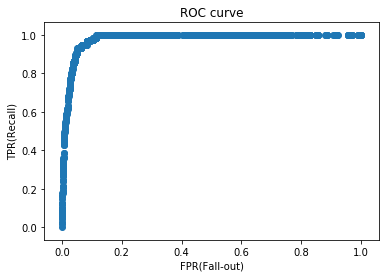

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

print('\nMdoel3 ROC CURVE')
x_val_processed = preprocessing.transform(x_val)
y_val_pred = model3.predict(x_val_processed)
y_val_pred_proba = model3.predict_proba(x_val_processed)[:,1]
print(classification_report(y_val, y_val_pred))
print('roc_auc_score = ', roc_auc_score(y_val, y_val_pred_proba))

fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');
plt.show()

In [ ]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('idx:', optimal_idx, ', threshold:', optimal_threshold)
print(roc[roc.Threshold == optimal_threshold])

y_val_pred_opt = y_val_pred_proba >= optimal_threshold

print('\nclassification report with optimal threshold')
print(classification_report(y_val, y_val_pred_opt))

idx: 500 , threshold: 0.04299472
     FPR(Fall-out)  TPRate(Recall)  Threshold
500        0.11536             1.0   0.042995

classification report with optimal threshold
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     12422
           1       0.08      1.00      0.14       117

    accuracy                           0.89     12539
   macro avg       0.54      0.94      0.54     12539
weighted avg       0.99      0.89      0.93     12539



In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

x_test_processed = preprocessing.transform(x_test)
y_test_pred = model3.predict(x_test_processed)
y_test_pred_proba = model3.predict_proba(x_test_processed)[:,1]
print('\nTest score')
print(classification_report(y_test, y_test_pred))
print('roc_auc_score = ', roc_auc_score(y_test, y_test_pred_proba))

print('\nTest score with optimal thredhold')
y_test_pred_opt = y_test_pred_proba >= optimal_threshold
print(classification_report(y_test_pred, y_test_pred_opt))



Test score
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15528
           1       0.25      0.70      0.37       146

    accuracy                           0.98     15674
   macro avg       0.62      0.84      0.68     15674
weighted avg       0.99      0.98      0.98     15674

roc_auc_score =  0.9802257345105262

Test score with optimal thredhold
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     15266
           1       0.21      1.00      0.35       408

    accuracy                           0.90     15674
   macro avg       0.61      0.95      0.65     15674
weighted avg       0.98      0.90      0.93     15674



In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    model3, # model
    scoring='roc_auc', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

x_test_processed = preprocessing.transform(x_test)
columns = preprocessing.named_steps['targetencoder'].get_feature_names()

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(x_test_processed, y_test);

eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성    
    feature_names = columns
)

Weight,Feature
0.2835 ± 0.0072,buying_items_among_coupon_items
0.0259 ± 0.0034,coupon_discount_rate
0.0134 ± 0.0045,coupon_discount
0.0065 ± 0.0030,campaign_type
0.0014 ± 0.0002,selling_price
0.0012 ± 0.0010,total_discount_rate
0.0011 ± 0.0006,other_discount
0.0010 ± 0.0005,buying_btype_among_coupon_btype
0.0010 ± 0.0008,campaign_duration
0.0007 ± 0.0006,income_bracket


        f0        f1        f2        f3  ...  f14  f15       f16       f17
0      1.0  0.011690  0.017438  0.057883  ...  1.0  1.0  0.093682  0.000273
1      0.0  0.035661  0.017438  0.000000  ...  1.0  1.0  0.177136  0.001726
2      0.0  0.011690  0.017438  0.057883  ...  1.0  1.0  0.224458  0.018597
3      0.0  0.021638  0.017438  0.000000  ...  1.0  1.0  0.174279  0.002186
4      0.0  0.035661  0.033977  0.000000  ...  1.0  1.0  0.152143  0.002565
...    ...       ...       ...       ...  ...  ...  ...       ...       ...
15669  0.0  0.029504  0.017438  0.000000  ...  1.0  1.0  0.156393  0.000000
15670  0.0  0.029504  0.027816  0.000000  ...  1.0  1.0  0.243322  0.014342
15671  0.0  0.011690  0.017438  0.057883  ...  1.0  1.0  0.257285  0.030793
15672  0.0  0.011690  0.017438  0.057883  ...  1.0  1.0  0.147454  0.001156
15673  0.0  0.011690  0.017438  0.057883  ...  1.0  1.0  0.668827  0.021592

[15674 rows x 18 columns]


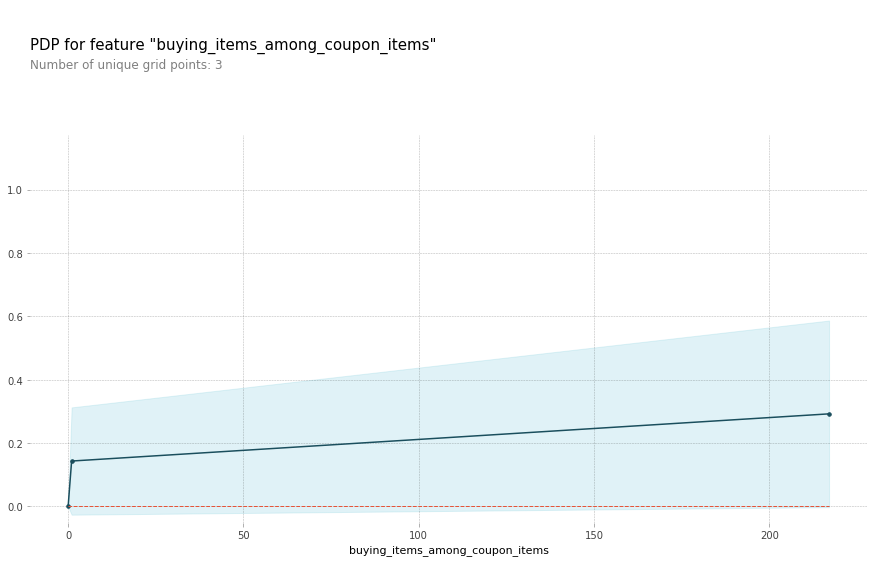

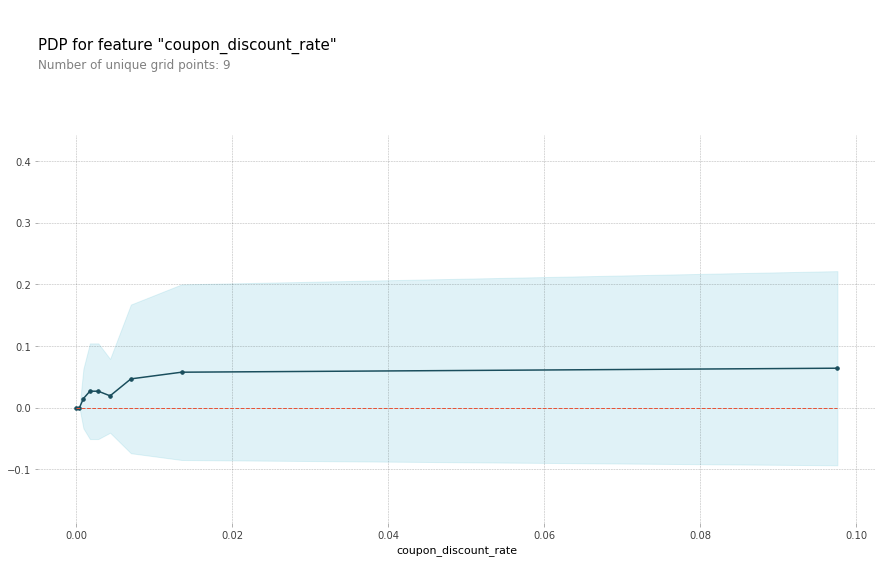

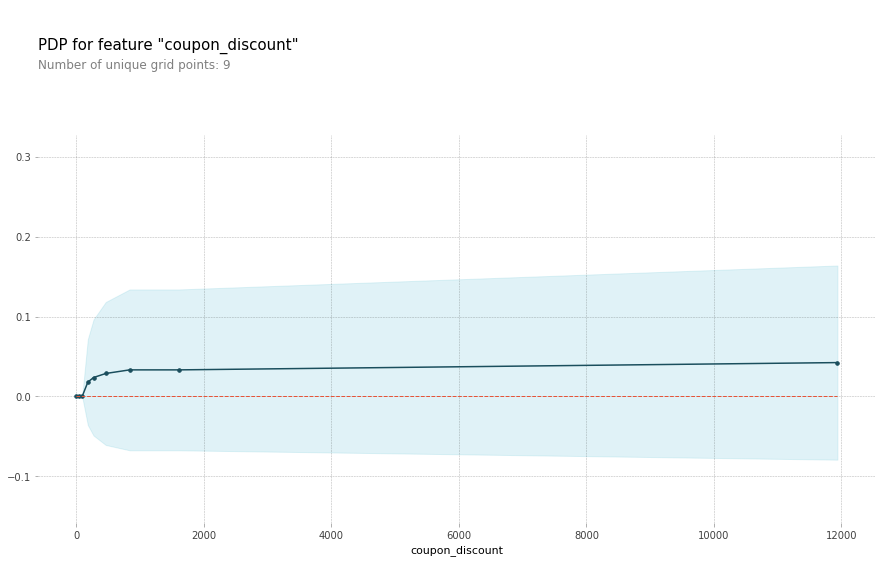

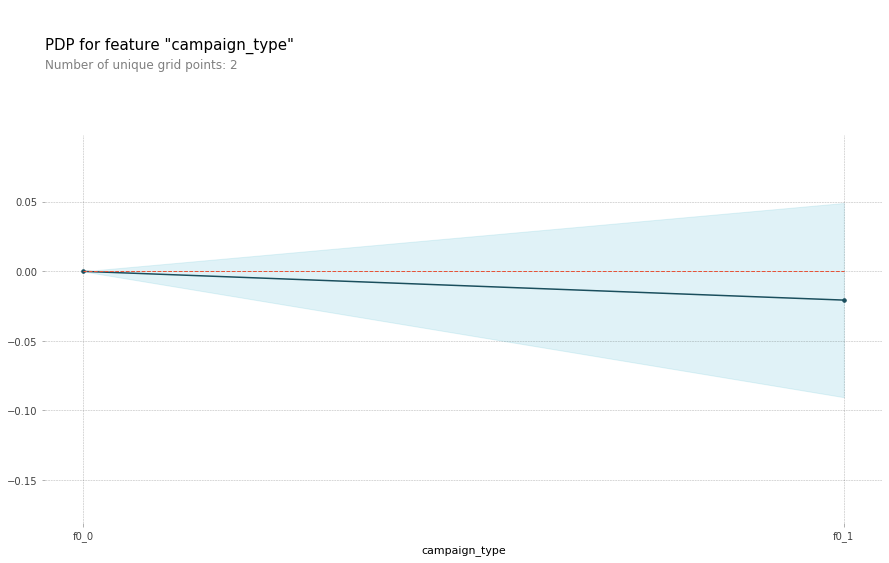

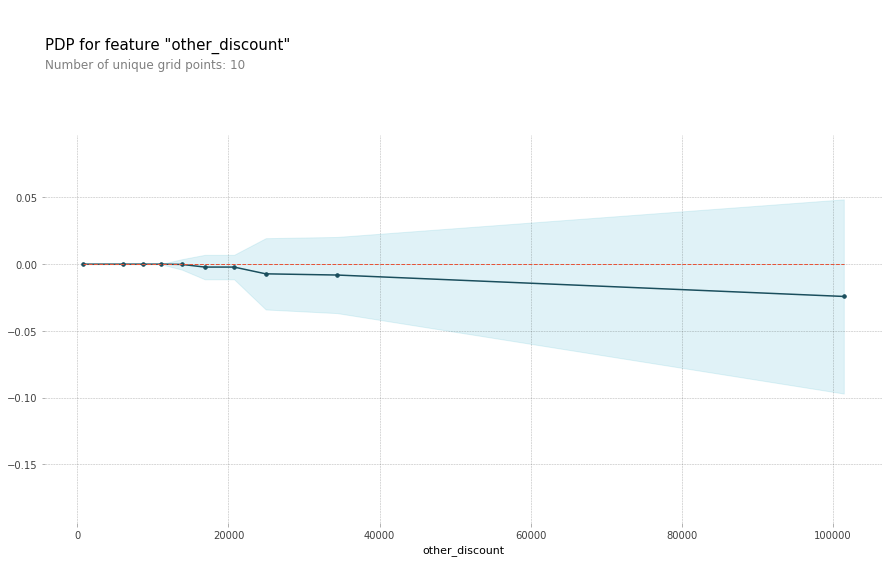

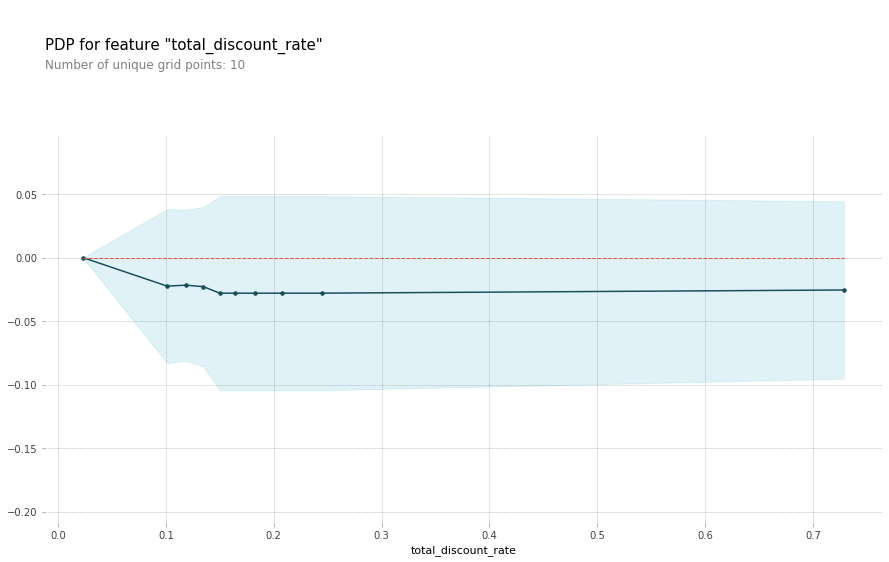

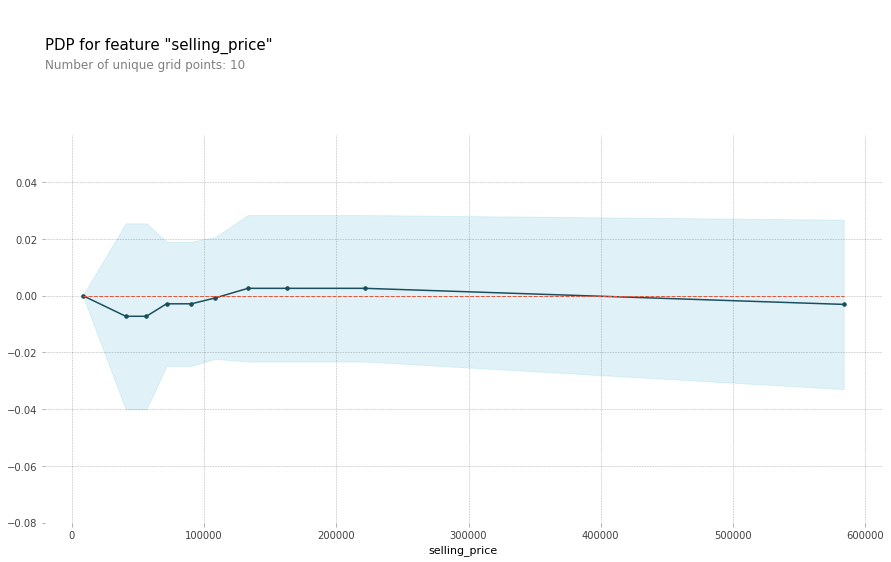

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

features = ['buying_items_among_coupon_items', 'coupon_discount_rate', 'coupon_discount', 'campaign_type', 'other_discount', 'total_discount_rate', 'selling_price']
x_test_processed = preprocessing.transform(x_test)
x_test_data = pd.DataFrame(x_test_processed)
x_test_data.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17']
org_col = x_test.columns.to_list()

print(x_test_data)
for feature in features :
  index = org_col.index(feature)
  isolated = pdp_isolate(
      model=model3, 
      dataset=x_test_data, 
      model_features=x_test_data.columns, 
      feature=x_test_data.columns[index],
      # grid point를 크게 주면 겹치는 점이 생겨 Number of unique grid points는 grid point 보다 작을 수 있습니다.
      num_grid_points=10, # grid 포인트를 더 줄 수 있습니다. default = 10
  )
  pdp_plot(isolated, feature_name=feature)

In [ ]:
import shap

explainer = shap.TreeExplainer(model3)
x_val_processed = preprocessing.transform(x_val)
shap_values_test = explainer.shap_values(x_val_processed[0:20])
x_data_new = pd.DataFrame(x_val_processed[0:20], columns = x_val.columns)

shap.initjs()

shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values_test,
    features=x_data_new,
    link = 'logit'
)